<a href="https://colab.research.google.com/github/w-oke/covid_reproduction/blob/main/covid_owid_2_analysis_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The data loaded in this Notebook is based on the output of: covid_owid_1_preparation.ipynb, which can be accessed from:
https://github.com/w-oke/covid_reproduction.

In [ ]:
import urllib.request
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from tensorflow import keras

In [ ]:
df_link = 'https://github.com/w-oke/covid_reproduction/raw/main/covid_owid_df.parquet'
df1 = pd.read_parquet(df_link)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14301 entries, 0 to 14300
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   iso_code                             14301 non-null  object        
 1   location                             14301 non-null  object        
 2   date                                 14301 non-null  datetime64[ns]
 3   reproduction_rate                    14301 non-null  float64       
 4   new_tests_smoothed_per_thousand      8803 non-null   float64       
 5   people_vaccinated_per_hundred        4093 non-null   float64       
 6   people_fully_vaccinated_per_hundred  3690 non-null   float64       
 7   total_boosters_per_hundred           738 non-null    float64       
 8   stringency_index                     13289 non-null  float64       
 9   population_density                   14064 non-null  float64       
 10  median_age

In [ ]:
df1.describe()

,reproduction_rate,new_tests_smoothed_per_thousand,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,stringency_index,population_density,median_age,gdp_per_capita,extreme_poverty,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Alpha,Beta,Delta,Epsilon,Eta,Gamma,Iota,Kappa,Lambda,Mu,Omicron,non_who
count,14301.000000,8803.000000,4093.000000,3690.000000,738.000000,13289.000000,14064.000000,13854.000000,13765.000000,9549.000000,7151.000000,12736.000000,14221.000000,13907.000000,14301.000000,14301.000000,14301.000000,14301.000000,14301.000000,14301.000000,14301.000000,14301.000000,14301.000000,14301.000000,14301.000000,14301.000000
mean,0.981942,2.622169,29.124486,22.970561,3.515393,56.023194,306.259138,30.405190,18884.689561,13.711687,50.390141,3.015318,72.882941,0.724233,15.087567,2.863510,25.805796,0.187539,0.336964,2.355922,0.162038,0.152970,0.705505,0.569767,0.001632,51.770789
std,0.307368,5.994082,25.946311,23.518525,7.522536,18.812211,1524.105201,9.162506,19696.509909,20.394417,32.011542,2.468386,7.693613,0.152332,24.067069,7.715949,39.575243,0.732054,1.751733,6.774350,0.924724,1.054033,3.335233,3.051138,0.043042,43.977821
min,-0.030000,0.002000,0.000000,0.000000,0.000000,0.000000,1.980000,15.100000,661.240000,0.100000,1.188000,0.100000,53.280000,0.394000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.020000
25%,0.830000,0.291000,4.200000,2.540000,0.000000,42.590000,36.253000,21.700000,4227.630000,0.500000,19.275000,1.300000,67.110000,0.594000,0.000000,0.000000,0.040375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.723235
50%,1.000000,0.977000,22.040000,13.795000,0.160000,56.480000,82.600000,29.700000,12294.876000,2.200000,49.542000,2.397000,74.470000,0.744000,0.640000,0.345000,0.502778,0.000643,0.000000,0.024545,0.000000,0.000000,0.000000,0.000000,0.000000,54.498500
75%,1.150000,2.614000,52.040000,40.397500,3.420000,70.830000,205.859000,38.700000,26808.164000,21.200000,83.241000,4.000000,78.570000,0.848000,23.769274,3.655000,55.913235,0.084615,0.239722,2.399407,0.070000,0.024111,0.711053,0.500397,0.000000,99.247750
max,3.200000,83.721000,98.100000,88.400000,43.360000,100.000000,19347.500000,48.200000,116935.600000,77.600000,98.999000,13.800000,86.750000,0.957000,100.000000,100.000000,100.000000,23.750000,62.800000,96.170000,34.730000,60.190000,82.080000,87.010000,4.920000,100.000000


Note that:
* about half the data has 'handwashing_facilities', 'extreme_poverty', and 'new_tests_smoothed_per_thousand'
* about a quarter of the data has vaccination data

It is thought that the reason that many of the vaccination and booster data values are null is due to the timeframes (2019-2020) and countries where no vaccinations were available or provided.  Most of these values could therefore be filled with 0 (zero).


In [ ]:
df1.head()

,iso_code,location,date,reproduction_rate,new_tests_smoothed_per_thousand,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,stringency_index,population_density,median_age,gdp_per_capita,extreme_poverty,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Alpha,Beta,Delta,Epsilon,Eta,Gamma,Iota,Kappa,Lambda,Mu,Omicron,non_who
0,AGO,Angola,2020-12-21,0.96,NaN,NaN,NaN,NaN,65.74,23.89,16.8,5819.495,NaN,26.664,NaN,61.15,0.581,0.000,74.19,0.0,0.0,1.08,0.0,0.0,0.0,0.0,0.0,0.0,24.730
1,AGO,Angola,2021-01-25,0.91,NaN,NaN,NaN,NaN,62.96,23.89,16.8,5819.495,NaN,26.664,NaN,61.15,0.581,5.770,3.85,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,90.380
2,AGO,Angola,2021-02-01,0.87,NaN,NaN,NaN,NaN,62.96,23.89,16.8,5819.495,NaN,26.664,NaN,61.15,0.581,7.645,16.21,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,76.145
3,AGO,Angola,2021-02-08,0.88,NaN,NaN,NaN,NaN,61.11,23.89,16.8,5819.495,NaN,26.664,NaN,61.15,0.581,9.520,28.57,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,61.910
4,AGO,Angola,2021-02-15,0.90,NaN,NaN,NaN,NaN,61.11,23.89,16.8,5819.495,NaN,26.664,NaN,61.15,0.581,6.040,34.80,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,59.160


In [ ]:
# column descriptions from OWID:
owid_col_desc_link = 'https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-codebook.csv'
owid_col_desc = pd.read_csv(owid_col_desc_link)
owid_col_desc.head()
# Note: the Variant data isn't described here, but is percentage by country or as calculated globally
# on that date if the country's data wasn't available.

,column,source,category,description
0,iso_code,International Organization for Standardization,Others,ISO 3166-1 alpha-3 – three-letter country codes
1,continent,Our World in Data,Others,Continent of the geographical location
2,location,Our World in Data,Others,Geographical location
3,date,Our World in Data,Others,Date of observation
4,total_cases,COVID-19 Data Repository by the Center for Sys...,Confirmed cases,Total confirmed cases of COVID-19


In [ ]:
# make sure that the var_dictionary.pkl matches the dataset imported above
var_link = 'https://github.com/w-oke/covid_reproduction/raw/main/covid_owid_var_dictionary.pkl'

a_file = "covid_owid_var_dictionary.pkl"
data = urllib.request.urlretrieve(var_link, a_file)

with open(a_file, 'rb') as f:
        var = pickle.load(f)

print('The variables in df have been categorized into 4 groups: ', print(var.keys()))
print()
var

dict_keys(['y', 'meta', 'number', 'variants'])
The variables in df have been categorized into 4 groups:  None



{'meta': ['date', 'iso_code', 'location'],
 'number': ['new_tests_smoothed_per_thousand',
  'people_vaccinated_per_hundred',
  'people_fully_vaccinated_per_hundred',
  'total_boosters_per_hundred',
  'stringency_index',
  'population_density',
  'median_age',
  'human_development_index',
  'gdp_per_capita',
  'extreme_poverty',
  'handwashing_facilities',
  'hospital_beds_per_thousand',
  'life_expectancy'],
 'variants': ['Alpha',
  'Beta',
  'Delta',
  'Epsilon',
  'Eta',
  'Gamma',
  'Iota',
  'Kappa',
  'Lambda',
  'Mu',
  'Omicron',
  'non_who'],
 'y': ['reproduction_rate']}

In [ ]:
# create a single list of all the features
var_all = [item for sublist in list(var.values()) for item in sublist]
print('The first 4 items in "var_all" are: ', var_all[0:4])
print('There are {} variables in var_all'.format(len(var_all)))

# create a single string of all the features
var_all2 = ', '.join(var_all)
print('var_all2: ', var_all2)

The first 4 items in "var_all" are:  ['reproduction_rate', 'date', 'iso_code', 'location']
There are 29 variables in var_all
var_all2:  reproduction_rate, date, iso_code, location, new_tests_smoothed_per_thousand, people_vaccinated_per_hundred, people_fully_vaccinated_per_hundred, total_boosters_per_hundred, stringency_index, population_density, median_age, human_development_index, gdp_per_capita, extreme_poverty, handwashing_facilities, hospital_beds_per_thousand, life_expectancy, Alpha, Beta, Delta, Epsilon, Eta, Gamma, Iota, Kappa, Lambda, Mu, Omicron, non_who


In [ ]:
(df1.date <= pd.Timestamp(2020,12,31)).sum()

5854

In [ ]:
df1.date.min()

Timestamp('2020-05-11 00:00:00')

In [ ]:
var['vaccine'] = ['people_vaccinated_per_hundred',
                  'people_fully_vaccinated_per_hundred',
                  'total_boosters_per_hundred']
# inpute vaccine columns with nulls if date <= 31 Dec 2020
df1.loc[df1.date <= pd.Timestamp(2020,12,31), var['vaccine']] = \
        df1.loc[df1.date <= pd.Timestamp(2020,12,31), var['vaccine']].fillna(0.0)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14301 entries, 0 to 14300
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   iso_code                             14301 non-null  object        
 1   location                             14301 non-null  object        
 2   date                                 14301 non-null  datetime64[ns]
 3   reproduction_rate                    14301 non-null  float64       
 4   new_tests_smoothed_per_thousand      8803 non-null   float64       
 5   people_vaccinated_per_hundred        9902 non-null   float64       
 6   people_fully_vaccinated_per_hundred  9531 non-null   float64       
 7   total_boosters_per_hundred           6592 non-null   float64       
 8   stringency_index                     13289 non-null  float64       
 9   population_density                   14064 non-null  float64       
 10  median_age

In [ ]:
type(df1.date.max()-df1.date.min())
(df1.date.max()-df1.date.min()).days

553

In [ ]:
# create an integer date_diff column to help with imputation
df1['date_diff'] = pd.TimedeltaIndex(df1.date - df1.date.min()).days
df1['date_diff'].head()

0    224
1    259
2    266
3    273
4    280
Name: date_diff, dtype: int64

In [ ]:
var['scale'] = var['number'] + var['variants'] + ['date_diff']
scaler = MinMaxScaler()
df2_scaled = pd.DataFrame(scaler.fit_transform(df1[var['scale']]), columns = var['scale'])
df2_scaled.head()

,new_tests_smoothed_per_thousand,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,stringency_index,population_density,median_age,human_development_index,gdp_per_capita,extreme_poverty,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,Alpha,Beta,Delta,Epsilon,Eta,Gamma,Iota,Kappa,Lambda,Mu,Omicron,non_who,date_diff
0,NaN,0.0,0.0,0.0,0.6574,0.001133,0.05136,0.332149,0.044363,NaN,0.260462,NaN,0.235136,0.00000,0.7419,0.0,0.0,0.017197,0.0,0.0,0.0,0.0,0.0,0.0,0.247451,0.405063
1,NaN,NaN,NaN,NaN,0.6296,0.001133,0.05136,0.332149,0.044363,NaN,0.260462,NaN,0.235136,0.05770,0.0385,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.903819,0.468354
2,NaN,NaN,NaN,NaN,0.6296,0.001133,0.05136,0.332149,0.044363,NaN,0.260462,NaN,0.235136,0.07645,0.1621,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.761498,0.481013
3,NaN,NaN,NaN,NaN,0.6111,0.001133,0.05136,0.332149,0.044363,NaN,0.260462,NaN,0.235136,0.09520,0.2857,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.619176,0.493671
4,NaN,NaN,NaN,NaN,0.6111,0.001133,0.05136,0.332149,0.044363,NaN,0.260462,NaN,0.235136,0.06040,0.3480,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.591682,0.506329


In [ ]:
imputer = KNNImputer(n_neighbors=10, add_indicator=False)

# use the KNN imputer to first impute values that won't vary significantly with time:
var['imputer_no_date'] = ['population_density', 'median_age',
       'gdp_per_capita', 'extreme_poverty', 'handwashing_facilities',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index']
df1[var['imputer_no_date']] = pd.DataFrame(imputer.fit_transform(df2_scaled[var['imputer_no_date']]),
                                        columns = var['imputer_no_date'])

# next, use the KNN imputer to impute time-sensitive health-related values:
var['imputer_date'] = ['new_tests_smoothed_per_thousand', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'gdp_per_capita', 'hospital_beds_per_thousand',
       'stringency_index', 'date_diff']
df1[var['imputer_date']] = pd.DataFrame(imputer.fit_transform(df2_scaled[var['imputer_date']]),
                                        columns = var['imputer_date'])

In [ ]:
df1.info() # the result is a fully populated DF:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14301 entries, 0 to 14300
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   iso_code                             14301 non-null  object        
 1   location                             14301 non-null  object        
 2   date                                 14301 non-null  datetime64[ns]
 3   reproduction_rate                    14301 non-null  float64       
 4   new_tests_smoothed_per_thousand      14301 non-null  float64       
 5   people_vaccinated_per_hundred        14301 non-null  float64       
 6   people_fully_vaccinated_per_hundred  14301 non-null  float64       
 7   total_boosters_per_hundred           14301 non-null  float64       
 8   stringency_index                     14301 non-null  float64       
 9   population_density                   14301 non-null  float64       
 10  median_age

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                        df1[var['number']+var['variants']], df1[var['y']], 
                        test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
                        X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu'),	# hidden ReLU layer
    keras.layers.Dense(units=128, activation='relu'),	# hidden ReLU layer 2
    #keras.layers.Dense(units=64, activation='relu'),	# hidden ReLU layer 3
    keras.layers.Dense(units=1)]) # linear output layer for regression
    #keras.layers.Dropout(rate=0.1)
model.compile(optimizer='adam',
              loss='mse',
              metrics=[keras.metrics.RootMeanSquaredError()])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=20,
                                               restore_best_weights=True)
lr_schedule = keras.callbacks.ReduceLROnPlateau(factor=0.2)
history = model.fit(X_train, y_train, # 'verbose = 0' turns off text output
    batch_size = 16, 	# number of examples in each batch before step
    epochs = 500, 		# will cycle through all trg data 500 times unless:
    callbacks=[early_stopping, lr_schedule], # put callbacks in a list; use lg epochs value
    validation_data = (X_val, y_val)) # to monitor performance

Epoch 1/500
537/537 [==============================] - 1s 2ms/step - loss: 0.0905 - root_mean_squared_error: 0.3009 - val_loss: 0.0923 - val_root_mean_squared_error: 0.3038 - lr: 1.0000e-04
Epoch 2/500
537/537 [==============================] - 1s 2ms/step - loss: 0.0912 - root_mean_squared_error: 0.3019 - val_loss: 0.0910 - val_root_mean_squared_error: 0.3017 - lr: 1.0000e-04
Epoch 3/500
537/537 [==============================] - 1s 2ms/step - loss: 0.0907 - root_mean_squared_error: 0.3011 - val_loss: 0.0923 - val_root_mean_squared_error: 0.3038 - lr: 1.0000e-04
Epoch 4/500
537/537 [==============================] - 1s 2ms/step - loss: 0.0896 - root_mean_squared_error: 0.2993 - val_loss: 0.0935 - val_root_mean_squared_error: 0.3058 - lr: 1.0000e-04
Epoch 5/500
537/537 [==============================] - 1s 2ms/step - loss: 0.0913 - root_mean_squared_error: 0.3022 - val_loss: 0.0959 - val_root_mean_squared_error: 0.3096 - lr: 1.0000e-04
Epoch 6/500
537/537 [=============================

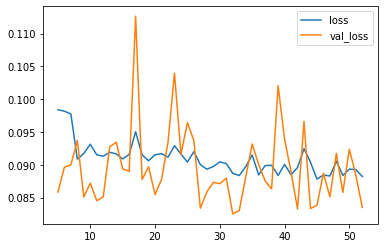

In [ ]:
history_df = pd.DataFrame(history.history) # convert the trg history to a DF
history_df.loc[5:, ['loss', 'val_loss']].plot()

In [ ]:
model.evaluate(X_test, y_test)

90/90 [==============================] - 0s 1ms/step - loss: 0.0844 - root_mean_squared_error: 0.2906


[0.08444170653820038, 0.2905885577201843]

In [ ]:
print("The Standard Deviation of the Reproduction Rate (the dependent variable) is {:.4f}".format(np.sqrt(float(df1[var['y']].var()))))

The Standard Deviation of the Reproduction Rate (the dependent variable) is 0.3074
